# Course #7 Resilience-Based Engineering: Cyber-Physical Modeling and Machine-Learning Towards Smart Electrical Equipment Systems

Summer 2024 Semester<br>
Professor Khalid M. Mosalam<br>
SSA: Fan Hu<br>
Department of Civil and Environmental Engineering<br>
University of California, Berkeley<br>

Welcome to Course 7: Cyber-Physical Modeling and Machine-Learning Towards Smart Electrical Equipment Systems. This notebook is meant to provide codes for your capstone project. Please read the __instructions__ as well as __comments in the code cells__ carefully.

You are required to fill in the sections that are clearly marked with `TODO` and constrained with rows of pound signs (i.e. `#######`). An example code blank is shown in the following cell. Check this document for more details.

In [4]:
# TODO: edit/complete the codes
####################################################################################################

print("Codes to edit/complete.") # Happy Coding :)

####################################################################################################

Codes to edit/complete.


We will be using some common Python libraries to help us process data. By convention, we import all libraries at the very top of the notebook. There are also a set of standard aliases that are used to shorten the library names (e.g., `np` for `numpy`). Run the cell below to import the libraries that you may need for this course project.

In [5]:
!pip install tensorflow

In [6]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import image
import os

import tensorflow as tf

from tensorflow.keras.layers import * # cannot use the alias 'tf' to import other modules
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *

import warnings
warnings.filterwarnings("ignore")

### Milestone 1

For this part, you are expected to run a simple Finite Element Method (FEM) analysis on a porcelain insulator. Hand derivations of $[K]$ and $\{P_0\}$ for the whole structure is required, and this following (optional) chuck of code is to help you with matrix manipulations and output final displacement results. Below code uses $m=5$ (therefore $n=m+1=6$) as an example.

In [7]:
pi = math.pi
E = 70000
A = 17671
H = 4000
gamma = 3.5e-5
d_top = 100
d_bottom = 200

# TODO: input K (dimenstion: 6x6) and P0 (dimension: 6)
# You have two options, 1) formulate the matrices using for-loop (recommended),
# OR 2) hand calculate the specific values of the matrices and fill in the blanks
# UNCOMMENT either option below.
####################################################################################################

# OPTION1: for-loop (recommended)

m = 5 #Number of elements
L_e = H / m  # Length of each element
A_top = np.pi * (d_top**2) / 4 #Calculate cross-sectional areas
A_bottom = np.pi * (d_bottom**2) / 4 #Calculate cross-sectional areas

# Cross-sectional areas for each element (linearly varying)
A_e = np.linspace(A_top, A_bottom, m)

# Initialize the matrices with zeros
K = np.zeros((m+1, m+1))
P0 = np.zeros(m+1)

# Populate global stiffness matrix and load vector
for i in range(m):
    # Local stiffness matrix and load vector for element i
    ke = (E * A_e[i] / L_e) * np.array([[1, -1], [-1, 1]])
    p0e = (gamma * A_e[i] * L_e / 2) * np.array([1, 1])

    # Assemble local matrices into global matrices
    K[i:i+2, i:i+2] += ke # Add the local stiffness matrix to the global stiffness matrix
    P0[i:i+2] += p0e # Add the local load vector to the global load vector

    # Apply concentrated load at node n (last node, here set to 0 for simplicity)
Pv = 0
P0[-1] += Pv

# OPTION2: hard-coding
# """
# K = np.array([
#     [  ,  ,  ,  ,  ,  ],
#     [  ,  ,  ,  ,  ,  ],
#     [  ,  ,  ,  ,  ,  ],
#     [  ,  ,  ,  ,  ,  ],
#     [  ,  ,  ,  ,  ,  ],
#     [  ,  ,  ,  ,  ,  ]
# ])

# P0 = np.array([
#     [  ],
#     [  ],
#     [  ],
#     [  ],
#     [  ],
#     [  ]
# ])
# """
####################################################################################################

# Handle the boundary condition, see the project description
K = K[1:, 1:]
P0 = P0[1:]
# print(K)
# print(P0)

# Do the matrix inversion and multiplication to calculate the nodal displacements for node 2-n
U = np.dot(np.linalg.inv(K), -P0)
print(U)

[-0.00384    -0.00578286 -0.00687086 -0.0074247  -0.0075847 ]


In [8]:
print(K)
# print(P0)

[[ 1889864.33067511 -1202640.93770234        0.                0.
         0.        ]
 [-1202640.93770234  2920699.42013426 -1718058.48243192        0.
         0.        ]
 [       0.         -1718058.48243192  3951534.50959341 -2233476.02716149
         0.        ]
 [       0.                0.         -2233476.02716149  4982369.59905256
  -2748893.57189107]
 [       0.                0.                0.         -2748893.57189107
   2748893.57189107]]


In [9]:
print(P0)

[302.37829291 467.31190722 632.24552153 797.17913585 439.8229715 ]


### Milestone 2

In this part, you are expected to complete the Python implementation of **Newmark's method** on linear systems.

In [10]:
# Two special cases of Newmark's method
# (1) Constant Average Acceleration Method
# gamma = 1/2
# beta = 1/4

# (2) Linear Acceleration Method
gamma = 1/2
beta = 1/6

In [11]:
# TODO: Fill in the blanks below to implement Newmark's method
####################################################################################################

m = 8000                         # kg
k = 36.4e6                       # N/m
zeta = 0.05                      # damping ratio

wn = np.sqrt(k / m)# TODO                      # rad/s
Tn = 2 * np.pi / wn# TODO                      # s
wd = wn * np.sqrt(1 - zeta**2)# TODO                      # rad/s
Td = 2 * np.pi / wd# TODO                      # s

c = 2 * zeta * wn * m# TODO                       # N*s/m


# Initial conditions
u_0 = 0
vel_0 = 0

delta_t = 0.01 # time intervals
duration = 5
time_step = int(duration / delta_t)
t = np.arange(0, duration + delta_t, delta_t)

p = 44500 * np.sin(20 * pi * t) * (t <= 0.6) # loading
p_0 = p[0]


# Initial calculations
acc_0 = (p_0 - k * u_0 - c * vel_0) / m# TODO
k_hat = k + beta * delta_t * c + gamma * delta_t**2 * m# TODO

a = 1 / (beta * delta_t**2 * m + k_hat)# TODO
b = (1 / (beta * delta_t * m)) - (c / (2 * beta * delta_t))# TODO


# Calculations for each time step, i
acc = [acc_0]
vel = [vel_0]
u = [u_0]

for i in range(0, time_step):
    delta_p_i = p[i+1] - p[i]
    delta_p_hat_i =  delta_p_i / (beta * delta_t**2)# TODO

    delta_u_i =  a * (delta_p_hat_i - k_hat * u[-1] - c * vel[-1] - m * acc[-1]) # TODO
    delta_vel_i = b * delta_u_i - delta_t * acc[-1]# TODO
    delta_acc_i = a * (delta_p_hat_i - k_hat * delta_u_i - c * delta_vel_i)# TODO

    u.append(u[-1] + delta_u_i)
    vel.append(vel[-1] + delta_vel_i)
    acc.append(acc[-1] + delta_acc_i)

assert(len(u) == len(vel) == len(acc) == time_step + 1)

####################################################################################################

Maximum Absolute Displacement: 3.036956702832507e+299 m


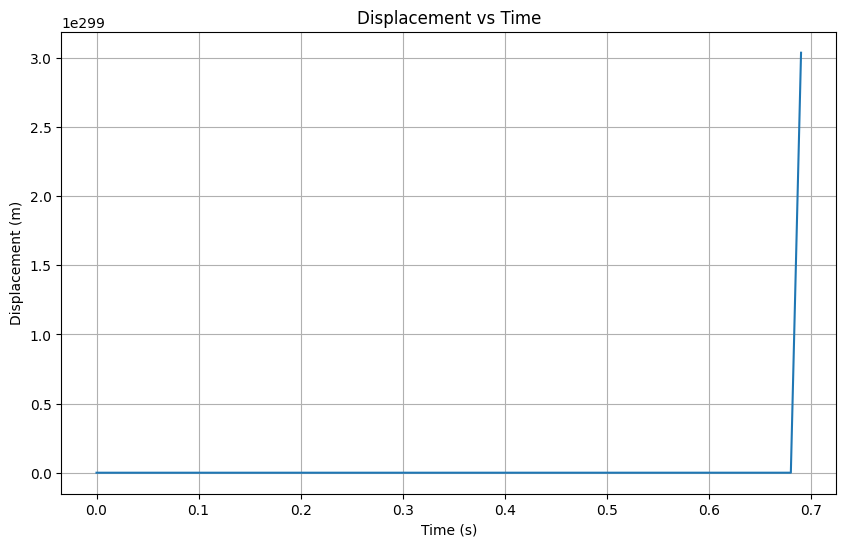

In [12]:
# TODO: Post-process the numerical results obtained
max_displacement = max(abs(np.array(u)))
####################################################################################################
print(f"Maximum Absolute Displacement: {max_displacement} m")

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(t, u)
plt.title("Displacement vs Time")
plt.xlabel("Time (s)")
plt.ylabel("Displacement (m)")
plt.grid(True)
plt.show()
####################################################################################################

The cell below is provided for students to (optionally) solve the extra credit problem: Python implementation of another time integrator.

In [13]:
# TODO: extra credit problem
####################################################################################################



####################################################################################################

### Milestone 4

For this part, you will train a Convolutional Neural Networks (CNN) classifier to identify the damages of transmission towers. You are expected to classify between undamaged/damaged states. Package `Keras` is used to train the CNN model, and the official documentation could be found in this [link](https://keras.io/guides/). For the layers and functions used below, you could search their names and find detailed explanations of the usage.

Images are loaded as 3-D tensors using the `load_data()` helper function defined below. You will design the CNN architectures by filling in the parameters for the Keras layers. Consequently, the model will be created and trained, and the accuracy for the test set will be reported.

You may want to read the comments carefully, and follow the instructions to complete the milestone. Specifically, you should design and fill in the architecture parameters of the classifier by following the comments that are marked with `CHOOSE`.

In [14]:
'''
Helper function for DEWA course 7 Milestone 4.

load_data() is used to load the images into NumPy arrays, which will be used in CNN classifiers later.

'''

def load_data(train_28=True):
    '''
    Load the data for CNN training.
    '''

    train_data = []
    train_label = []
    test_data = []
    test_label = []

    if (train_28):
        size = '28'
    else:
        size = '224'

    size_n = int(size)

    for file in os.listdir('Datasets/train_' + size + '/D/'):
        if (file[-4:] == ".jpg"):
            train_data.append(image.imread('Datasets/train_' + size + '/D/' + file).reshape((size_n, size_n, 1)))
            train_label.append([0, 1])
    for file in os.listdir('Datasets/train_' + size + '/UD/'):
        if (file[-4:] == ".jpg"):
            train_data.append(image.imread('Datasets/train_' + size + '/UD/' + file).reshape((size_n, size_n, 1)))
            train_label.append([1, 0])
    for file in os.listdir('Datasets/test_' + size + '/D/'):
        if (file[-4:] == ".jpg"):
            test_data.append(image.imread('Datasets/test_' + size + '/D/' + file).reshape((size_n, size_n, 1)))
            test_label.append([0, 1])
    for file in os.listdir('Datasets/test_' + size + '/UD/'):
        if (file[-4:] == ".jpg"):
            test_data.append(image.imread('Datasets/test_' + size + '/UD/' + file).reshape((size_n, size_n, 1)))
            test_label.append([1, 0])

    train_data = np.array(train_data)
    train_label = np.array(train_label)
    test_data = np.array(test_data)
    test_label = np.array(test_label)
    return [train_data, train_label, test_data, test_label]

Before starting the milestone, checked that you successfully installed packages keras and tensorflow by running the following code. No errors should be reported.

In [15]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.17.0


Some prior knowledge about **Batch Normalization**: (from CS182 Spring 2022 @ UC Berkeley)

The main idea behind Batch Normalization is to transform every sampled batch of data so that they have $\mu = 0$, $\sigma^2 = 1$. Using Batch Normalization typically makes networks significantly more robust to poor initialization. It is based on the intuition that it is better to have unit Gaussian inputs to layers at initialization. However, the reason why batch normalization works is not entirely understood, and there are conflicting views between whether Batch Normalization reduces covariate shift, improves smoothness over the optimization landscape, or other reasons.

In practice, when using batch normalization, we add a BatchNorm layer immediately _after_ each FC or convolutional layer, either _before_ or _after_ the non-linearity. The key observation is that normalization is a relatively simple differentiable operation, so we do not add too much additional complexity in the network.

Next, complete the codes below to train the classifier.

In [16]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Load the data
X_train, Y_train, X_test, Y_test = load_data(train_28=True)

# Specify the model input data shape
X_input = Input((X_train.shape[1], X_train.shape[2], 1))


# TODO: choose values for the parameters specified in the comment that starts with CHOOSE
####################################################################################################

# Apply the Convolutional layer to the images
# Padding is used to keep the image size same after Convolutional layer
# CHOOSE number of filters (filters). Recommended values are between 5 and 100
# CHOOSE filter size (kernel_size) in two directions. Recommended values are (3,3), (5,5), (7,7)
# Number of filters
filters = 64

# Filter size (kernel_size) in two directions
kernel_size = (3, 3)

# Apply the Convolutional layer to the images
X = Conv2D(filters=filters, kernel_size=kernel_size, padding="same")(X_input)

# Use normalization to improve training performance
X = BatchNormalization(axis=3)(X)

# CHOOSE an activation function: 'sigmoid', 'relu', 'tanh', etc
X = Activation('relu')(X)

# CHOOSE pooling Layer: select between MaxPooling2D and AveragePooling2D
X = AveragePooling2D(pool_size=(2,2))(X)

# Flatten X (i.e. convert the 3-D tensor into a 1-D vector)
X = Flatten()(X)

# CHOOSE the number of Fully-Connected layers
# CHOOSE the number of neurons and an activation function ('sigmoid', 'relu', 'tanh', etc) for each layer
# Recommended number of layers is 2, as shown below
# The number of neurons for layers could be different,
# and it is recommended that later layers have less units
X = Dense(units= 128, activation='relu')(X)
X = Dense(units= 64, activation='relu')(X)


# Final output, Do NOT change the setting in this layer
Y_output = Dense(2, activation='softmax')(X)

# Create the model. This creates your Keras model instance, you'll use this instance to train/test the model.
model = Model(inputs=X_input, outputs=Y_output)

# Adam optimizer is used for training the model
# CHOOSE learning rate (lr): recommended values are between 1e-6 and 1e-3
optimizer = Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Learning rate is reduced when the loss is not decreasing
# Used to improve model performance
reduce_learning_rate = ReduceLROnPlateau(monitor='loss', factor=0.9, patience=20, verbose=1)

# Train the model with training set images
# The verbose is turned on, so that students could observe the change of loss and training set accuracy for each epoch
# CHOOSE the number of epochs (epochs) and batch size (batch_size)
# Number of epochs are recommended to be between 20 and 1000
# Batch size should be between 1 and size of training data (362 in our case),
# and recommended values are powers of 2 (to improve efficiency in training)
model.fit(X_train, Y_train, epochs=20, verbose=True, batch_size=64, callbacks=[reduce_learning_rate])

####################################################################################################

# Output the test set accuracy by evaluating on the test set
print("The test set accuracy is {}".format(model.evaluate(X_test, Y_test, verbose=False)[1]))

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - accuracy: 0.5490 - loss: 1.0994 - learning_rate: 0.0010
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - accuracy: 0.7607 - loss: 0.5381 - learning_rate: 0.0010
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.8111 - loss: 0.4224 - learning_rate: 0.0010
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.8240 - loss: 0.4042 - learning_rate: 0.0010
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.8549 - loss: 0.3505 - learning_rate: 0.0010
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.8731 - loss: 0.2910 - learning_rate: 0.0010
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.8783 - loss: 0.2799 - learning_rate: 0.0010
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.9084 - loss: 0.2486 - learning_rate: 0.0010
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.9130 - loss: 0.2449 - learning_rate: 0.0010
Epoch 10/20
6/6 ━━━━━━━━━━━

In [17]:
# from google.colab import drive
# drive.mount('/content/drive')

Now you have successfully trained a CNN! You may need to change the model architecture to improve the accuracy, or you may work with the larger size images (i.e., train_224, test_224) by using the following block of code. You may copy the parameters above into the block below as the start point to train on the larger dataset.

In [18]:
# Load the data
X_train, Y_train, X_test, Y_test = load_data(train_28=False)

# Specify the model input data shape
X_input = Input((X_train.shape[1], X_train.shape[2], 1))


# TODO: choose values for the parameters specified in the comment that starts with CHOOSE
####################################################################################################

# First layer
X = Conv2D(filters= 128, kernel_size=(  3  , 3  ), padding="same")(X_input)
X = BatchNormalization(axis=3)(X)
X = Activation('relu')(X)
X = AveragePooling2D(pool_size=(2,2))(X)

# Second layer
# You could use the same set of parameters as the first layer, or different set of parameters
X = Conv2D(filters=  64  , kernel_size=(  3  ,  3  ), padding="same")(X)
X = BatchNormalization(axis=3)(X)
X = Activation('relu')(X)
X = AveragePooling2D(pool_size=(2,2))(X)

# You can also add the third or more layers

# Flatten X (i.e. convert the 3-D tensor into a vector)
X = Flatten()(X)

# CHOOSE the number of Fully-Connected layers
# CHOOSE the number of neurons and an activation function ('sigmoid', 'relu', 'tanh', etc) for each layer
# Recommended number of layers is 2, as shown below
# The number of neurons for layers could be different,
# and it is recommended that later layers has less units
X = Dense(units= 64, activation='relu')(X)
X = Dense(units= 32, activation='relu')(X)

# Final output, Do NOT change the setting in this layer
Y_output = Dense(2, activation='softmax')(X)

# Create the model. This creates your Keras model instance, you'll use this instance to train/test the model.
model = Model(inputs=X_input, outputs=Y_output)

# Adam optimizer is used for training the model
# CHOOSE learning rate (lr): recommended values are between 1e-6 and 1e-3
optimizer = Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Learning rate is reduced when the loss is not decreasing
# Used to improve model performance
reduce_learning_rate = ReduceLROnPlateau(monitor='loss', factor=0.9, patience=20, verbose=1)

# Train the model with training set images
# The verbose is turned on, so that students could observe the change of loss and training set accuracy for each epoch
# CHOOSE the number of epochs (epochs) and batch size (batch_size)
# Number of epochs are recommended to be between 20 and 1000
# Batch size should be between 1 and size of training data (362 in our case),
# and recommended values are powers of 2 (to improve efficiency in training)
model.fit(X_train, Y_train, epochs=50, verbose=True, batch_size=64, callbacks=[reduce_learning_rate])

####################################################################################################

# Output the test set accuracy by evaluating on the test set
print("The test set accuracy is {}".format(model.evaluate(X_test, Y_test, verbose=False)[1]))

Epoch 1/50


The cell below is provided for students to (optionally) solve the extra credit problem: Classification using your own datasets.

In [ ]:
# TODO: extra credit problem
####################################################################################################



####################################################################################################

That's it for this milestone! You will need to submit this Jupyter Notebook with the report on Gradescope. Congrats for completing this course! :)